# Load Libraries

In [2]:
# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

import os, sys, gc, warnings, random
from typing import List

import datetime
import dateutil.relativedelta

# Data manipulation
import pandas as pd 
import numpy as np

# EDA
from ydata_profiling import ProfileReport

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')

# Machine learning
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve, roc_curve
from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold, GroupKFold
from sklearn.ensemble import RandomForestClassifier
from scipy import stats

import lightgbm as lgb

from tqdm.notebook import trange, tqdm

from IPython.display import display

%matplotlib inline

pd.options.display.max_rows = 10000
pd.options.display.max_columns = 1000
pd.options.display.max_colwidth = 1000

# 숫자 포맷 설정
# pd.options.display.float_format = '{:,.0f}'.format

# font
plt.rc('font', family='AppleGothic')

# EDA

## 데이터 전체 윤곽 확인

In [3]:
# Load data
train_data = pd.read_csv('data/train.csv')
test_data = pd.read_csv('data/test.csv')

In [4]:
# test data
test_data.head(2)

,ID,대출금액,대출기간,근로기간,주택소유상태,연간소득,부채_대비_소득_비율,총계좌수,대출목적,최근_2년간_연체_횟수,총상환원금,총상환이자,총연체금액,연체계좌수
0,TEST_00000,16800000,36 months,8 years,MORTGAGE,132000000,19.64,12,주택 개선,0,394692,146604.0,0.0,0.0
1,TEST_00001,8400000,36 months,5 years,RENT,89971200,15.84,25,부채 통합,0,0,0.0,0.0,0.0


In [5]:
# train data
train_data.head()

,ID,대출금액,대출기간,근로기간,주택소유상태,연간소득,부채_대비_소득_비율,총계좌수,대출목적,최근_2년간_연체_횟수,총상환원금,총상환이자,총연체금액,연체계좌수,대출등급
0,TRAIN_00000,12480000,36 months,6 years,RENT,72000000,18.90,15,부채 통합,0,0,0.0,0.0,0.0,C
1,TRAIN_00001,14400000,60 months,10+ years,MORTGAGE,130800000,22.33,21,주택 개선,0,373572,234060.0,0.0,0.0,B
2,TRAIN_00002,12000000,36 months,5 years,MORTGAGE,96000000,8.60,14,부채 통합,0,928644,151944.0,0.0,0.0,A
3,TRAIN_00003,14400000,36 months,8 years,MORTGAGE,132000000,15.09,15,부채 통합,0,325824,153108.0,0.0,0.0,C
4,TRAIN_00004,18000000,60 months,Unknown,RENT,71736000,25.39,19,주요 구매,0,228540,148956.0,0.0,0.0,B


In [6]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96294 entries, 0 to 96293
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ID            96294 non-null  object 
 1   대출금액          96294 non-null  int64  
 2   대출기간          96294 non-null  object 
 3   근로기간          96294 non-null  object 
 4   주택소유상태        96294 non-null  object 
 5   연간소득          96294 non-null  int64  
 6   부채_대비_소득_비율   96294 non-null  float64
 7   총계좌수          96294 non-null  int64  
 8   대출목적          96294 non-null  object 
 9   최근_2년간_연체_횟수  96294 non-null  int64  
 10  총상환원금         96294 non-null  int64  
 11  총상환이자         96294 non-null  float64
 12  총연체금액         96294 non-null  float64
 13  연체계좌수         96294 non-null  float64
 14  대출등급          96294 non-null  object 
dtypes: float64(4), int64(5), object(6)
memory usage: 11.0+ MB


In [7]:
train_data.describe(include='all')

,ID,대출금액,대출기간,근로기간,주택소유상태,연간소득,부채_대비_소득_비율,총계좌수,대출목적,최근_2년간_연체_횟수,총상환원금,총상환이자,총연체금액,연체계좌수,대출등급
count,96294,9.629400e+04,96294,96294,96294,9.629400e+04,96294.000000,96294.000000,96294,96294.000000,9.629400e+04,9.629400e+04,96294.000000,96294.000000,96294
unique,96294,NaN,2,16,4,NaN,NaN,NaN,12,NaN,NaN,NaN,NaN,NaN,7
top,TRAIN_00000,NaN,36 months,10+ years,MORTGAGE,NaN,NaN,NaN,부채 통합,NaN,NaN,NaN,NaN,NaN,B
freq,1,NaN,64479,31585,47934,NaN,NaN,NaN,55150,NaN,NaN,NaN,NaN,NaN,28817
mean,NaN,1.830400e+07,NaN,NaN,NaN,9.392672e+07,19.379590,25.304827,NaN,0.345681,8.225035e+05,4.282282e+05,54.380584,0.005805,NaN
std,NaN,1.032908e+07,NaN,NaN,NaN,9.956871e+07,33.569559,12.088566,NaN,0.919119,1.027745e+06,4.402111e+05,1414.769218,0.079966,NaN
min,NaN,1.200000e+06,NaN,NaN,NaN,0.000000e+00,0.000000,4.000000,NaN,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,NaN
25%,NaN,1.020000e+07,NaN,NaN,NaN,5.760000e+07,12.650000,17.000000,NaN,0.000000,3.075720e+05,1.346160e+05,0.000000,0.000000,NaN
50%,NaN,1.680000e+07,NaN,NaN,NaN,7.800000e+07,18.740000,24.000000,NaN,0.000000,5.976960e+05,2.870040e+05,0.000000,0.000000,NaN
75%,NaN,2.400000e+07,NaN,NaN,NaN,1.128000e+08,25.540000,32.000000,NaN,0.000000,1.055076e+06,5.702160e+05,0.000000,0.000000,NaN


In [8]:
# 결측치 없음
train_data.isnull().sum().sum()

0

## Pandas Profiling

In [9]:
profile = ProfileReport(train_data, title="Profiling Report")

In [11]:
# profile.to_notebook_iframe()

### 상관관계 분석

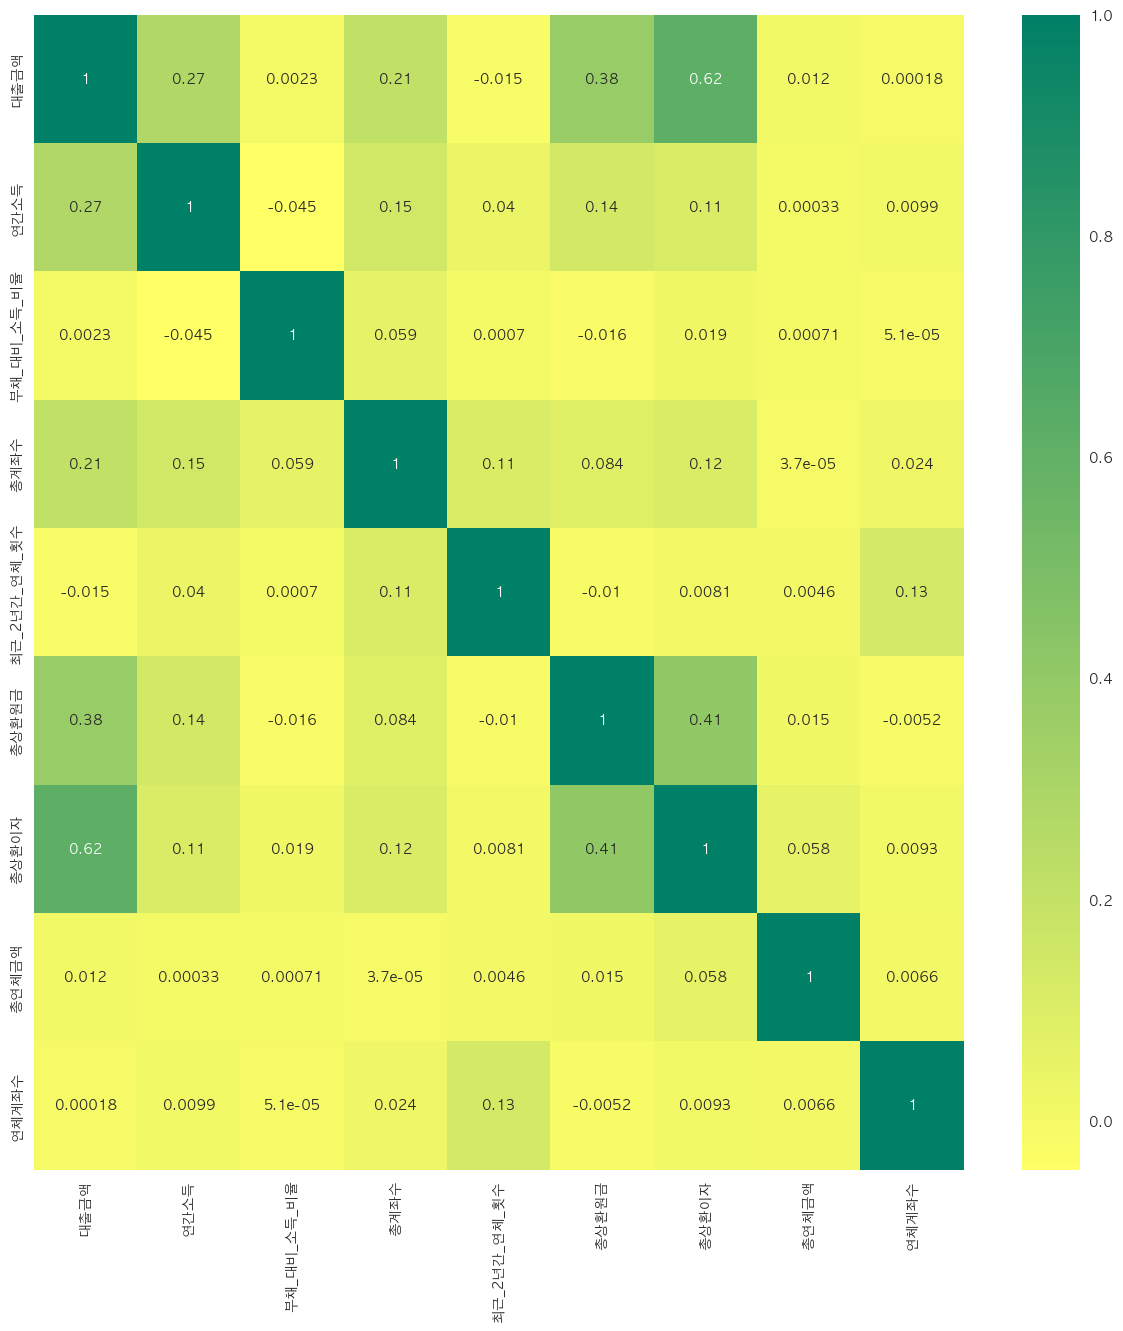

In [13]:
plt.figure(figsize=(15, 15), dpi=100)
sns.heatmap(train_data.corr(), annot=True, cmap="summer_r")
plt.show()

## 컬럼별 확인

In [379]:
train_data.columns

Index(['ID', '대출금액', '대출기간', '근로기간', '주택소유상태', '연간소득', '부채_대비_소득_비율', '총계좌수',
       '대출목적', '최근_2년간_연체_횟수', '총상환원금', '총상환이자', '총연체금액', '연체계좌수', '대출등급'],
      dtype='object')

### 대출금액

In [380]:
train_data['대출금액'].describe()

count       96,294
mean    18,303,998
std     10,329,076
min      1,200,000
25%     10,200,000
50%     16,800,000
75%     24,000,000
max     42,000,000
Name: 대출금액, dtype: float64

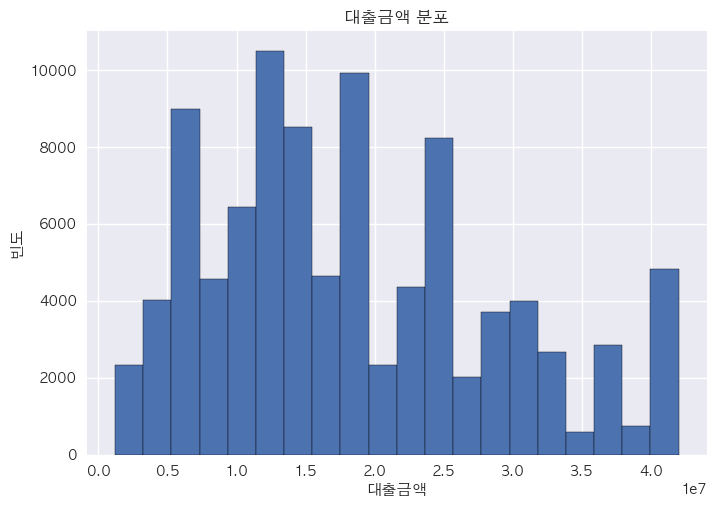

In [381]:
plt.hist(train_data['대출금액'], bins=20, edgecolor='k')
plt.xlabel('대출금액')
plt.ylabel('빈도')
plt.title('대출금액 분포')
plt.show()

### 대출기간

In [382]:
train_data['대출기간'].unique()

array([' 36 months', ' 60 months'], dtype=object)

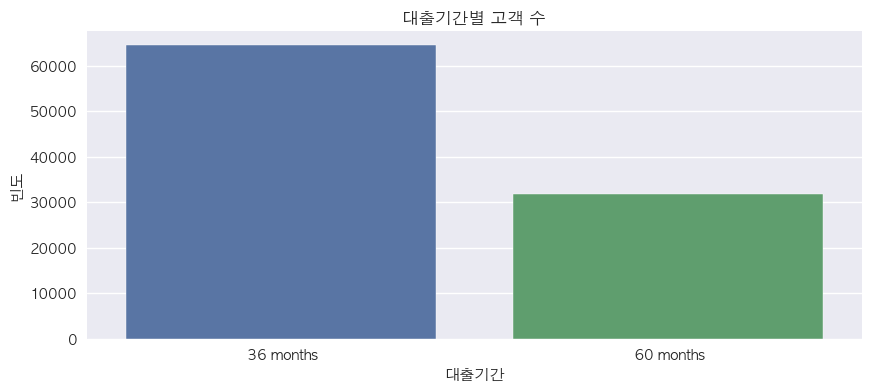

In [383]:
plt.figure(figsize=(10, 4))
sns.countplot(train_data, x='대출기간')
plt.xlabel('대출기간')
plt.ylabel('빈도')
plt.title('대출기간별 고객 수')
plt.show()

대출기간이 짧은 (36개월) 경우가 긴 (60개월) 경우보다 2배 가량 많다. 단기와 장기에 대한 차이를 반영하여 새로운 피쳐로 생성 필요

### 근로기간

In [384]:
train_data['근로기간'].unique()

array(['6 years', '10+ years', '5 years', '8 years', 'Unknown', '9 years',
       '2 years', '1 year', '3 years', '7 years', '4 years', '< 1 year',
       '10+years', '<1 year', '3', '1 years'], dtype=object)

In [385]:
# '근로기간' 컬럼 데이터 매핑
mapping = {
    '6 years': 6,
    '10+ years': 10,
    '5 years': 5,
    '8 years': 8,
    'Unknown': 0,
    '9 years': 9,
    '2 years': 2,
    '1 year': 1,
    '3 years': 3,
    '7 years': 7
}

temp = train_data.copy()

# '근로기간' 컬럼을 숫자로 변환
temp['근로기간'] = temp['근로기간'].map(mapping)

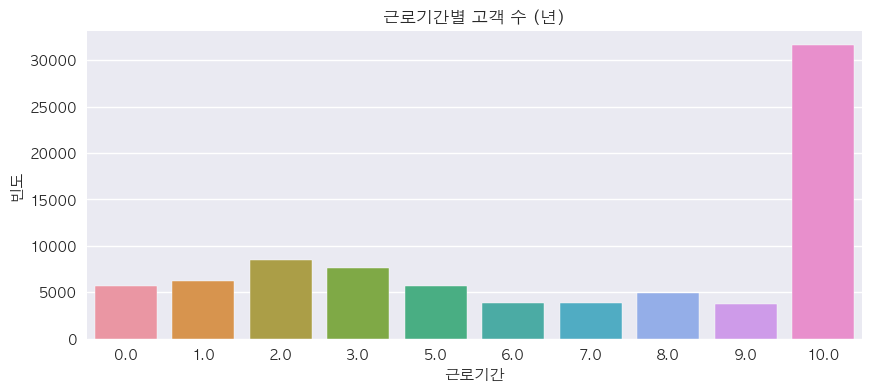

In [386]:
plt.figure(figsize=(10, 4))
sns.countplot(temp, x='근로기간')
plt.xlabel('근로기간')
plt.ylabel('빈도')
plt.title('근로기간별 고객 수 (년)')
plt.show()

근로기간을 숫자형 변수로 변환 필요

### 주택소유상태

In [387]:
train_data['주택소유상태'].unique()

array(['RENT', 'MORTGAGE', 'OWN', 'ANY'], dtype=object)

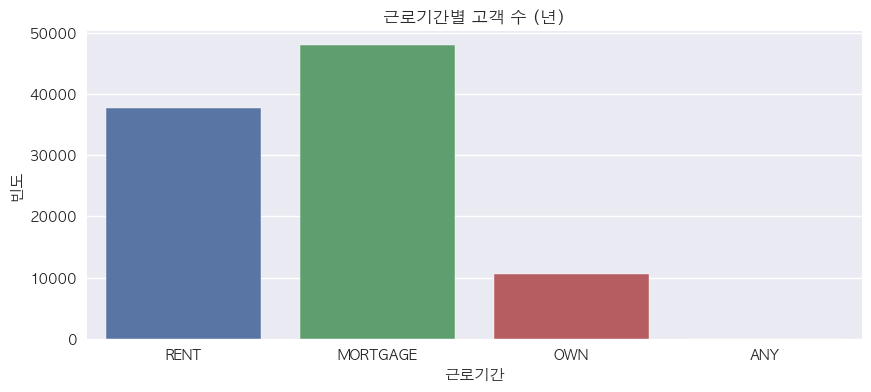

In [388]:
plt.figure(figsize=(10, 4))
sns.countplot(temp, x='주택소유상태')
plt.xlabel('근로기간')
plt.ylabel('빈도')
plt.title('근로기간별 고객 수 (년)')
plt.show()

### 연간소득

In [389]:
train_data['연간소득'].describe()

count           96,294
mean        93,926,725
std         99,568,708
min                  0
25%         57,600,000
50%         78,000,000
75%        112,800,000
max     10,800,000,000
Name: 연간소득, dtype: float64

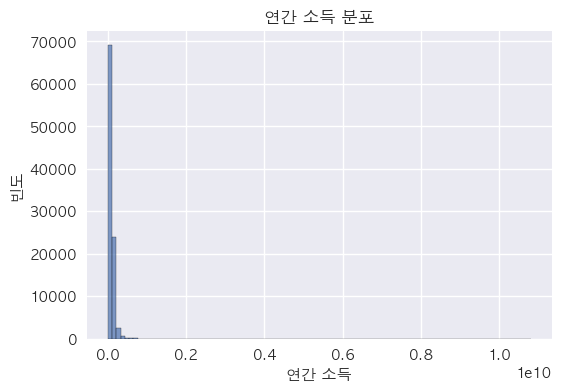

In [390]:
# 연간소득 금액 분포
plt.figure(figsize=(6, 4))
plt.hist(train_data['연간소득'], bins=100, edgecolor='k', alpha=0.7)
plt.xlabel('연간 소득')
plt.ylabel('빈도')
plt.title('연간 소득 분포')
plt.show()

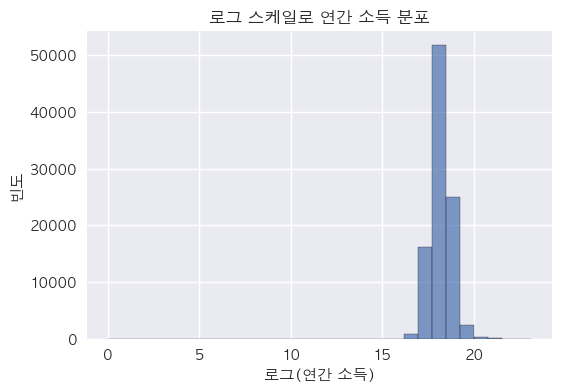

In [391]:
# 대출등급별 연간소득 분포 (로그 스케일)
plt.figure(figsize=(6, 4))
plt.hist(np.log1p(train_data['연간소득']), bins=30, edgecolor='k', alpha=0.7)
plt.xlabel('로그(연간 소득)')
plt.ylabel('빈도')
plt.title('로그 스케일로 연간 소득 분포')
plt.show()

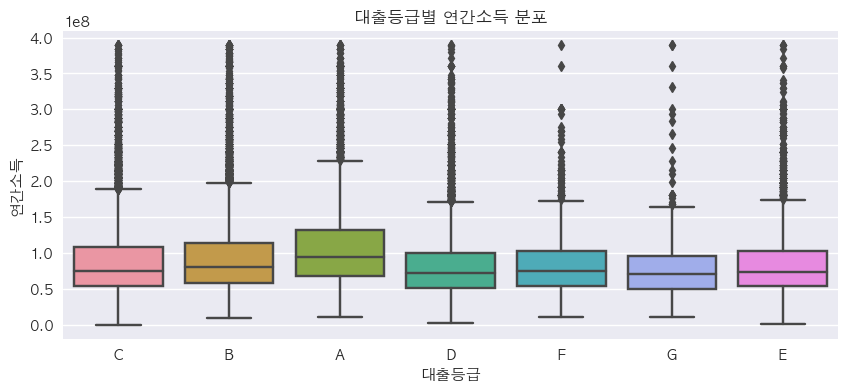

In [392]:
# 아웃라이어 제거

# '연간소득'과 '대출등급' 컬럼을 선택하여 데이터프레임 생성
year_income = train_data[['연간소득','대출등급']].copy()
z_scores = stats.zscore(year_income['연간소득'])
threshold = 3  # 임계값 설정
filtered_data = year_income[(z_scores < threshold) & (z_scores > -threshold)]
plt.figure(figsize=(10, 4))
sns.boxplot(x='대출등급', y='연간소득', data=filtered_data)
plt.xlabel('대출등급')
plt.ylabel('연간소득')
plt.title('대출등급별 연간소득 분포')
plt.show()

### 부채_대비_소득_비율

In [393]:
train_data['부채_대비_소득_비율'].describe()

count   96,294
mean        19
std         34
min          0
25%         13
50%         19
75%         26
max      9,999
Name: 부채_대비_소득_비율, dtype: float64

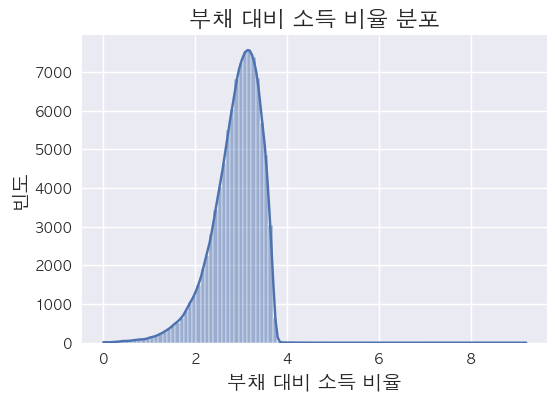

In [394]:
# log1p 적용
plt.figure(figsize=(6, 4))
sns.histplot(np.log1p(train_data['부채_대비_소득_비율']), bins=100, kde=True)
plt.xlabel('부채 대비 소득 비율', fontsize=14)
plt.ylabel('빈도', fontsize=14)
plt.title('부채 대비 소득 비율 분포', fontsize=16)
plt.show()

### 총계좌수

In [395]:
train_data['총계좌수'].describe()

count   96,294
mean        25
std         12
min          4
25%         17
50%         24
75%         32
max        169
Name: 총계좌수, dtype: float64

### 대출목적

In [396]:
train_data['대출목적'].unique()

array(['부채 통합', '주택 개선', '주요 구매', '휴가', '의료', '자동차', '신용 카드', '소규모 사업',
       '기타', '이사', '주택', '재생 에너지'], dtype=object)

### 최근 2년간 연체 횟수

In [397]:
train_data.최근_2년간_연체_횟수.describe()

count   96,294
mean         0
std          1
min          0
25%          0
50%          0
75%          0
max         30
Name: 최근_2년간_연체_횟수, dtype: float64

### 총상환원금

In [398]:
train_data.총상환원금.describe()

count       96,294
mean       822,503
std      1,027,745
min              0
25%        307,572
50%        597,696
75%      1,055,076
max     41,955,936
Name: 총상환원금, dtype: float64

대출기간에 따른 상환 원금의 비율 등등 구할 수 있음

### 총상환이자

In [399]:
train_data.총상환이자.describe()

count      96,294
mean      428,228
std       440,211
min             0
25%       134,616
50%       287,004
75%       570,216
max     5,653,416
Name: 총상환이자, dtype: float64

### 총연체금액

In [400]:
train_data['총연체금액'].unique()

array([    0., 21792., 18000., 46536., 25284., 33996., 52308., 46500.,
       40716., 39588., 20292., 50064., 75768., 38712., 19116., 35304.,
       19212., 24000.,  6000., 19608., 18660., 44688., 20124.,  4800.,
       25512., 52032., 45576., 74076., 36888., 31416., 35868., 24180.,
       27900., 44496., 24300., 21696., 19620., 18288., 52428., 31320.,
       52884., 30192., 75216., 32088., 19944., 52836., 25524., 57276.,
       26148., 32316., 20196., 30780., 23628., 19200., 70044., 12000.,
       72000., 24600., 28356., 37440., 31308., 28884., 48300., 43584.,
       36000., 35148., 20136., 44292., 19128., 57672., 43968., 24864.,
       26760., 37704., 21264., 60396., 31860., 72864., 21252., 72444.,
       59184., 26436., 27300.,  2400., 40872., 41388., 26412., 28692.,
       21444., 52452., 35376., 23592., 21324., 21240., 53712., 28716.,
       41592., 24096., 60576., 19800., 26160., 41352., 42276., 48000.,
       29964., 30636., 30600., 32052., 38292.])

In [401]:
train_data.총연체금액.describe()

count   96,294
mean        54
std      1,415
min          0
25%          0
50%          0
75%          0
max     75,768
Name: 총연체금액, dtype: float64

연체 금액은 있는 사람과 없는 사람으로 구분해볼 수 있음

### 연체계좌수

In [402]:
train_data.연체계좌수.unique()

array([0., 1., 2., 4.])

### 대출등급

In [403]:
train_data['대출등급'].unique()

array(['C', 'B', 'A', 'D', 'F', 'G', 'E'], dtype=object)

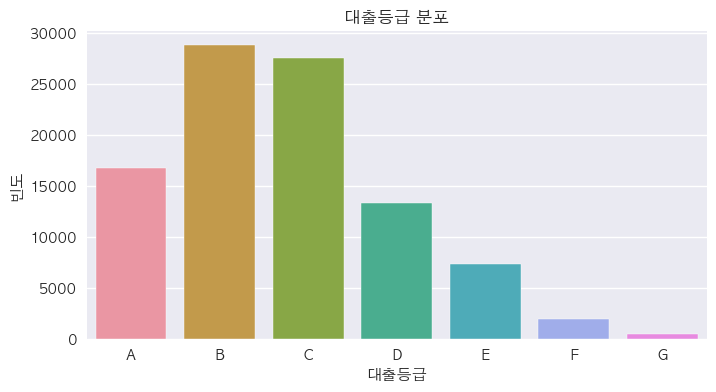

In [404]:
plt.figure(figsize=(8, 4))
sns.countplot(train_data, x='대출등급', order=['A','B','C','D','E','F','G'])
plt.xlabel('대출등급')
plt.ylabel('빈도')
plt.title('대출등급 분포')
plt.show()

############################################################################################

# Fix Seed

In [405]:
'''
    결과의 재현성을 위해 seed 값을 설정하는 함수
'''
def seed_everything(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    
SEED = 42
seed_everything(SEED)

# 레이블 생성 함수 정의

# 전처리 함수 정의

In [406]:
def preprocessing(dataframe):
    # ID
    try:
        # ID Columns Drop (만약 'ID' 컬럼이 존재하면 삭제)
        dataframe = dataframe.drop('ID', axis=1)
    except KeyError:
        # 'ID' 컬럼이 존재하지 않는 경우, 아무 작업도 하지 않고 그대로 진행
        pass
    
    # object column 처리
    # 대출기간
    dataframe['대출기간'] = dataframe['대출기간'].str.extract('(\d+)').astype(int)
    # 근로기간
    values_map=dict({'6 years':6,
     '10+ years':10,
     '5 years':5,
     '8 years':8,
     '9 years':9,
     '2 years':2,
     '1 years':1,
     '3 years':3,
     '7 years':7,
     '4 years':4,
     '< 1 year':0,
     'Unknown':-1})
    dataframe['근로기간'] = dataframe['근로기간'].map(values_map)
    # 주택소유상태, 대출목적
    dataframe = pd.get_dummies(dataframe, columns=['주택소유상태','대출목적'], prefix=['주택소유상태','대출목적'])

    # 대출등급(y) 값 매핑
    try:
        class_mapping = {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6}
        dataframe['대출등급'] = dataframe['대출등급'].map(class_mapping)
    except KeyError:
        # 해당 컬럼이 존재하지 않는 경우, 아무 작업도 하지 않고 그대로 진행
        pass
    
    return dataframe

# 피처 엔지니어링 함수 정의

In [407]:
def feature_engineering(dataframe):
    
    return dataframe

# 전처리 및 피쳐 엔지니어링 실행

In [408]:
# preprocessing
train_data = preprocessing(train_data)
test_data = preprocessing(test_data)

In [409]:
# feature engineering
# train_data = feature_engineering(train_data)
# test_data = feature_engineering(test_data)

In [410]:
train_data.head(3)

,대출금액,대출기간,근로기간,연간소득,부채_대비_소득_비율,총계좌수,최근_2년간_연체_횟수,총상환원금,총상환이자,총연체금액,연체계좌수,대출등급,주택소유상태_ANY,주택소유상태_MORTGAGE,주택소유상태_OWN,주택소유상태_RENT,대출목적_기타,대출목적_부채 통합,대출목적_소규모 사업,대출목적_신용 카드,대출목적_의료,대출목적_이사,대출목적_자동차,대출목적_재생 에너지,대출목적_주요 구매,대출목적_주택,대출목적_주택 개선,대출목적_휴가
0,12480000,36,6,72000000,19,15,0,0,0,0,0,2,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0
1,14400000,60,10,130800000,22,21,0,373572,"234,060",0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,12000000,36,5,96000000,9,14,0,928644,"151,944",0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [411]:
test_data.head(3)

,대출금액,대출기간,근로기간,연간소득,부채_대비_소득_비율,총계좌수,최근_2년간_연체_횟수,총상환원금,총상환이자,총연체금액,연체계좌수,주택소유상태_MORTGAGE,주택소유상태_OWN,주택소유상태_RENT,대출목적_결혼,대출목적_기타,대출목적_부채 통합,대출목적_소규모 사업,대출목적_신용 카드,대출목적_의료,대출목적_이사,대출목적_자동차,대출목적_재생 에너지,대출목적_주요 구매,대출목적_주택,대출목적_주택 개선,대출목적_휴가
0,16800000,36,8,132000000,20,12,0,394692,"146,604",0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,8400000,36,5,89971200,16,25,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
2,17280000,36,6,150000000,8,20,0,1786980,"281,820",0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0


# 머신 러닝

In [412]:
# 훈련 데이터와 검증 데이터 분리
X_train, X_valid, y_train, y_valid = train_test_split(train_data.drop('대출등급', axis=1), train_data['대출등급'], test_size=0.2)

# XGBoost 모델 설정 및 학습
model = xgb.XGBClassifier(objective='multi:softmax', num_class=5)
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None, num_class=5,
              num_parallel_tree=None, ...)

In [413]:
# 훈련 데이터 평가
y_pred_train = model.predict(X_train)
train_f1 = f1_score(y_train, y_pred_train, average='macro')
train_precision = precision_score(y_train, y_pred_train, average='macro')
train_recall = recall_score(y_train, y_pred_train, average='macro')
train_roc_auc = roc_auc_score(pd.get_dummies(y_train), model.predict_proba(X_train), multi_class='ovr')

# 검증 데이터 평가
y_pred_valid = model.predict(X_valid)
valid_f1 = f1_score(y_valid, y_pred_valid, average='macro')
valid_precision = precision_score(y_valid, y_pred_valid, average='macro')
valid_recall = recall_score(y_valid, y_pred_valid, average='macro')
valid_roc_auc = roc_auc_score(pd.get_dummies(y_valid), model.predict_proba(X_valid), multi_class='ovr')

In [417]:
test_data.columns

Index(['대출금액', '대출기간', '근로기간', '연간소득', '부채_대비_소득_비율', '총계좌수', '최근_2년간_연체_횟수',
       '총상환원금', '총상환이자', '총연체금액', '연체계좌수', '주택소유상태_MORTGAGE', '주택소유상태_OWN',
       '주택소유상태_RENT', '대출목적_결혼', '대출목적_기타', '대출목적_부채 통합', '대출목적_소규모 사업',
       '대출목적_신용 카드', '대출목적_의료', '대출목적_이사', '대출목적_자동차', '대출목적_재생 에너지',
       '대출목적_주요 구매', '대출목적_주택', '대출목적_주택 개선', '대출목적_휴가'],
      dtype='object')

In [414]:
# 테스트 데이터에 모델 적용 (예측)
def predict_with_xgboost(model, test_data):
    # 모델을 사용하여 테스트 데이터에 대한 예측 수행
    predictions = model.predict(test_data)
    
    # 예측 결과를 DataFrame에 추가
    test_data['대출등급'] = predictions
    
    return test_data['대출등급']

# 테스트 데이터에 대한 예측 수행
predictions_df = predict_with_xgboost(model, test_data)

# 예측 결과 출력
print(predictions_df)

ValueError: feature_names mismatch: ['대출금액', '대출기간', '근로기간', '연간소득', '부채_대비_소득_비율', '총계좌수', '최근_2년간_연체_횟수', '총상환원금', '총상환이자', '총연체금액', '연체계좌수', '주택소유상태_ANY', '주택소유상태_MORTGAGE', '주택소유상태_OWN', '주택소유상태_RENT', '대출목적_기타', '대출목적_부채 통합', '대출목적_소규모 사업', '대출목적_신용 카드', '대출목적_의료', '대출목적_이사', '대출목적_자동차', '대출목적_재생 에너지', '대출목적_주요 구매', '대출목적_주택', '대출목적_주택 개선', '대출목적_휴가'] ['대출금액', '대출기간', '근로기간', '연간소득', '부채_대비_소득_비율', '총계좌수', '최근_2년간_연체_횟수', '총상환원금', '총상환이자', '총연체금액', '연체계좌수', '주택소유상태_MORTGAGE', '주택소유상태_OWN', '주택소유상태_RENT', '대출목적_결혼', '대출목적_기타', '대출목적_부채 통합', '대출목적_소규모 사업', '대출목적_신용 카드', '대출목적_의료', '대출목적_이사', '대출목적_자동차', '대출목적_재생 에너지', '대출목적_주요 구매', '대출목적_주택', '대출목적_주택 개선', '대출목적_휴가']
expected 주택소유상태_ANY in input data
training data did not have the following fields: 대출목적_결혼

# 피쳐 중요도

In [ ]:

# Feature Importance 출력
feature_importance = pd.DataFrame({'feature': X_train.columns, 'importance': model.feature_importances_})
feature_importance = feature_importance.sort_values(by='importance', ascending=False)


# 평가지표 출력

In [ ]:

# 결과 출력
print("Train F1 Score:", train_f1)
print("Train Precision:", train_precision)
print("Train Recall:", train_recall)
print("Train ROC AUC Score:", train_roc_auc)
print("\nValidation F1 Score:", valid_f1)
print("Validation Precision:", valid_precision)
print("Validation Recall:", valid_recall)
print("Validation ROC AUC Score:", valid_roc_auc)
print("\nFeature Importance:")
print(feature_importance)

# Submission 파일 저장